In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from torch import optim

import torchvision.transforms as transforms
from torchvision import datasets
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [8]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5), std=(1.0))])

path = "C:\\Users\\161332\\Documents\\github\\AI_study\\05_DL(PyTorch)"

trainset = datasets.FashionMNIST(root = path,
                          train=True, transform=mnist_transform,
                          download=True)

testset = datasets.FashionMNIST(root = path,
                         train = False, transform=mnist_transform,
                         download=True)


train_loader = DataLoader(dataset=trainset,
                          batch_size = 10,
                          shuffle=True)
test_loader = DataLoader(dataset=testset,
                         batch_size = 10,
                         shuffle=False)

26422272it [00:06, 4118280.10it/s]                                                                                     


Extracting C:\Users\161332\Documents\github\AI_study\05_DL(PyTorch)\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\161332\Documents\github\AI_study\05_DL(PyTorch)\FashionMNIST\raw



29696it [00:00, 99583.25it/s]                                                                                          


Extracting C:\Users\161332\Documents\github\AI_study\05_DL(PyTorch)\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\161332\Documents\github\AI_study\05_DL(PyTorch)\FashionMNIST\raw



4422656it [00:03, 1320177.91it/s]                                                                                      


Extracting C:\Users\161332\Documents\github\AI_study\05_DL(PyTorch)\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\161332\Documents\github\AI_study\05_DL(PyTorch)\FashionMNIST\raw



6144it [00:00, 6159130.92it/s]                                                                                         

Extracting C:\Users\161332\Documents\github\AI_study\05_DL(PyTorch)\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\161332\Documents\github\AI_study\05_DL(PyTorch)\FashionMNIST\raw



In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images.shape, labels.shape

(torch.Size([10, 1, 28, 28]), torch.Size([10]))

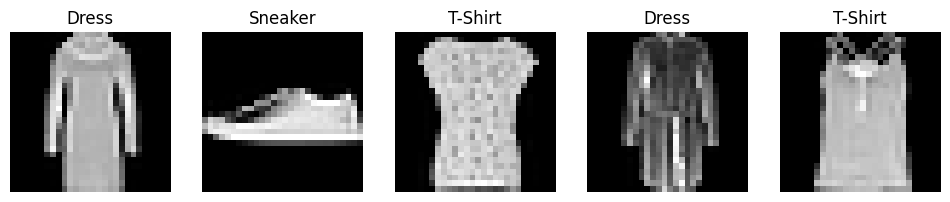

In [10]:
labels_map = {
    0 : 'T-Shirt',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle Boot'
}

figure = plt.figure(figsize=(12, 12))
cols, rows = 5, 1
for i in range(cols * rows):
    image = images[i].squeeze()
    label_idx = labels[i].item()
    label = labels_map[label_idx]

    figure.add_subplot(rows, cols, i+1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

In [11]:
# 모델 정의
class BasicBlock(nn.Module):
    """
    Basic Block for resnet 18 and resnet 34
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.5):
        super().__init__()

        # residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
            nn.Dropout2d(p=dropout_prob)
        )

        # shortcut
        self.shortcut = nn.Sequential()
        """
        the shortcut output dimension is not the same with residual fuction
        use 1 * 1 convolution to match the dimension
        """
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        # we use a different inputsize than the original paper
        # so conv2_x's stride is 1

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks -1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [12]:
model = resnet34().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train(model, train_loader, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_accuracy = 100 * correct / total

    return running_loss / len(train_loader), train_accuracy

In [14]:
def evaluate(model, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)

            test_loss += criterion(output, target).item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    test_accuracy = 100 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [15]:
num_epochs = 10
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(1, num_epochs+1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print("[{}] Train loss : {:.4f} Test loss: {:.4f}, Train_acc : {:.2f} Test_acc: {:.2f}".format(epoch, train_loss, test_loss, train_accuracy, test_accuracy))
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

[1] Train loss : 0.6599 Test loss: 0.3835, Train_acc : 76.13 Test_acc: 85.47
[2] Train loss : 0.3793 Test loss: 0.3026, Train_acc : 86.30 Test_acc: 88.72
[3] Train loss : 0.3120 Test loss: 0.2896, Train_acc : 88.65 Test_acc: 89.62
[4] Train loss : 0.2742 Test loss: 0.2549, Train_acc : 90.17 Test_acc: 90.78
[5] Train loss : 0.2464 Test loss: 0.2505, Train_acc : 91.00 Test_acc: 91.20
[6] Train loss : 0.2230 Test loss: 0.2289, Train_acc : 91.94 Test_acc: 91.87
[7] Train loss : 0.2063 Test loss: 0.2305, Train_acc : 92.40 Test_acc: 92.02
[8] Train loss : 0.1895 Test loss: 0.2326, Train_acc : 93.01 Test_acc: 92.19
[9] Train loss : 0.1781 Test loss: 0.2325, Train_acc : 93.56 Test_acc: 92.34
[10] Train loss : 0.1652 Test loss: 0.2326, Train_acc : 93.91 Test_acc: 92.66


In [16]:
PATH = './fashion_mnist_resnet34.pth'
torch.save(model.state_dict(), PATH)

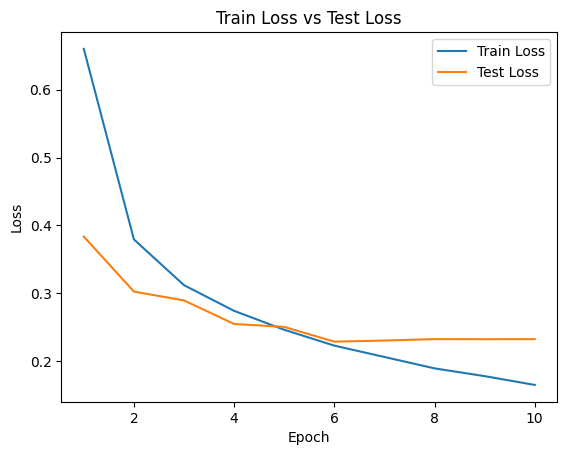

In [17]:
# train_losses와 test_losses 리스트를 사용하여 그래프 그리기
# batch = 10, optimizer = optim.Adam(model.parameters(), lr=0.001) + dropout
# [10] Train loss : 0.1652 Test loss: 0.2326, Train_acc : 93.91 Test_acc: 92.66
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

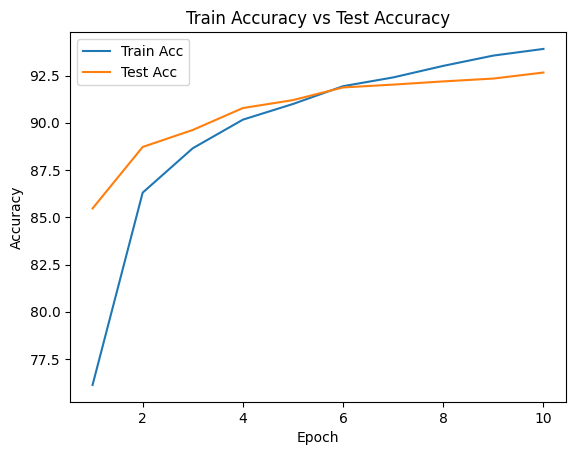

In [19]:
# train_acc test_acc 리스트를 사용하여 그래프 그리기
# batch = 10, optimizer = optim.Adam(model.parameters(), lr=0.001) + dropout
# [10] Train loss : 0.1652 Test loss: 0.2326, Train_acc : 93.91 Test_acc: 92.66
plt.plot(range(1, num_epochs+1), train_acc, label='Train Acc')
plt.plot(range(1, num_epochs+1), test_acc, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Test Accuracy')
plt.legend()
plt.show()